In [66]:
# imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.stattools import coint
from statsmodels.api import OLS
import yfinance as yf

In [76]:
# Get price data for PHYSX and GLD from yfinance
phys = pd.read_excel('excel_data/PHYS.xlsx')
phys.head()

,Date,Close,NAV
0,2023-01-20,14.92,15.2667
1,2023-01-19,14.96,15.3157
2,2023-01-18,14.74,15.0929
3,2023-01-17,14.79,15.1294
4,2023-01-16,NaN,15.1877


<AxesSubplot:title={'center':'PHYSX Close and NAV'}>

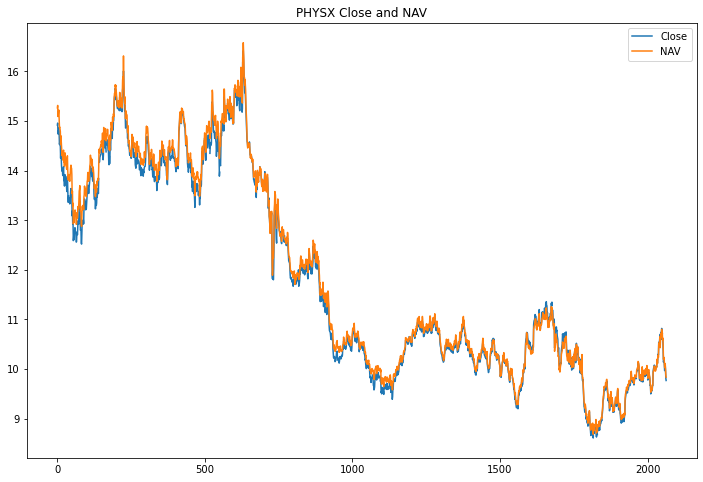

In [77]:
# Show a time series of the close and NAV values for PHYS
phys[['Close', 'NAV']].plot(figsize=(12, 8), title='PHYSX Close and NAV')

<AxesSubplot:title={'center':'PHYSX Close and NAV Daily Percent Change'}>

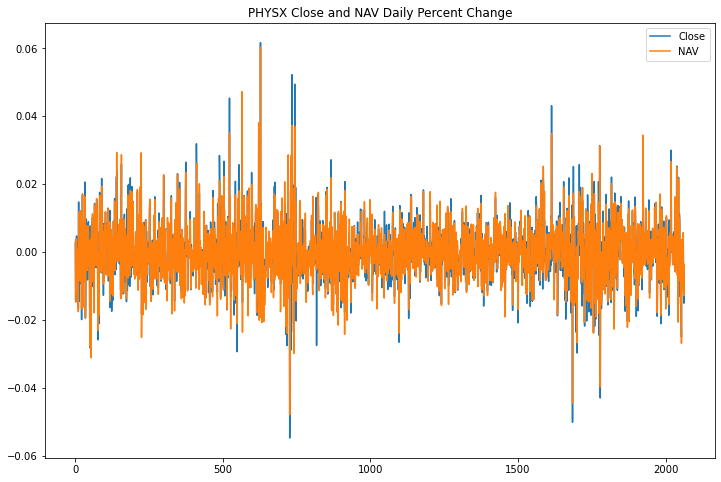

In [78]:
# Plot the daily percent changes against eachother as a time series
phys[['Close', 'NAV']].pct_change().plot(figsize=(12, 8), title='PHYSX Close and NAV Daily Percent Change')

<AxesSubplot:title={'center':'PHYSX Close and NAV Daily Percent Change'}, xlabel='Close', ylabel='NAV'>

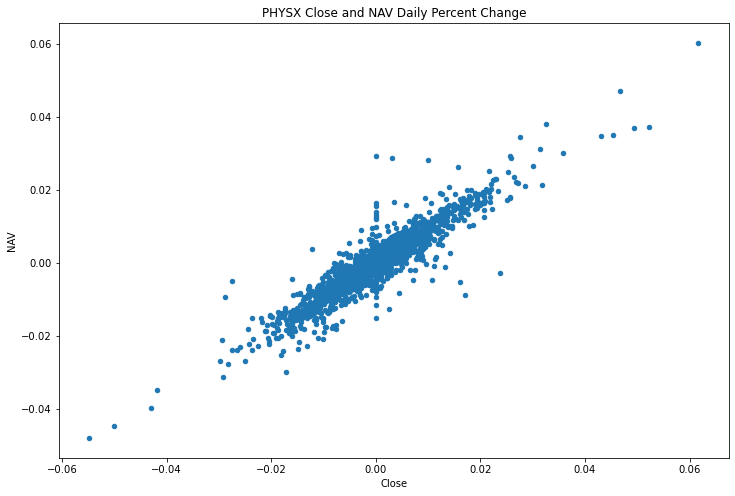

In [79]:
# plot the daily percent changes against eachother as a scatter plot
phys[['Close', 'NAV']].pct_change().plot.scatter(x='Close', y='NAV', figsize=(12, 8), title='PHYSX Close and NAV Daily Percent Change')

<AxesSubplot:title={'center':'PHYSX Premium/Discount'}>

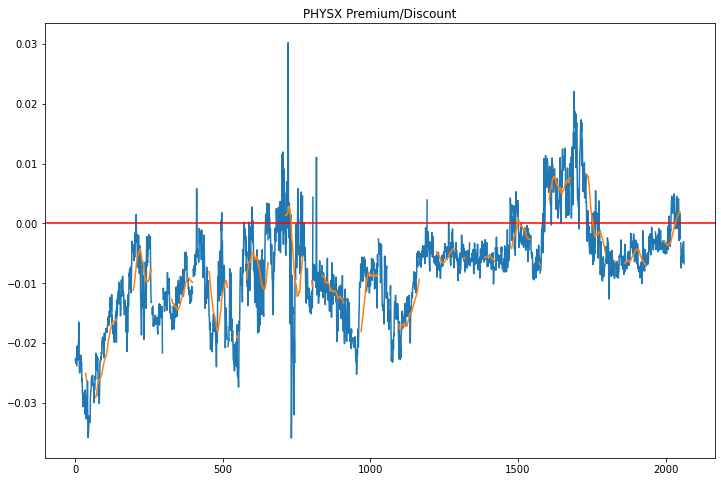

In [80]:
# Plot the premium/discount between the NAV and Close
pmd = phys['Close'] / phys['NAV'] - 1
pmd.plot(figsize=(12, 8), title='PHYSX Premium/Discount')
plt.axhline(0, color='r')
pmd.rolling(30).mean().plot(figsize=(12, 8), title='PHYSX Premium/Discount')  # <-- simple moving average

Determining if the two are cointegrated

In [81]:
df = phys
df.reset_index(inplace=True)
df.set_index('Date', inplace=True)
df.sort_index(inplace=True)
df = df.drop(['index'], axis=1)
df.head()

,Close,NAV
Date,,
2014-12-31,9.77,9.8363
2015-01-02,9.82,9.8722
2015-01-05,9.97,10.0006
2015-01-06,10.07,10.1131
2015-01-07,10.02,10.0553


In [82]:
print(f'Number of days in dataset: {len(df)}')

Number of days in dataset: 2064


In [83]:
# Segregate out data only for the years 2018 - 2019
df_1 = df['2018-01-01':'2019-12-31']
df_1.head()

,Close,NAV
Date,,
2018-01-02,10.71,10.7840
2018-01-03,10.69,10.7487
2018-01-04,10.76,10.8267
2018-01-05,10.75,10.7987
2018-01-08,10.75,10.8075


In [84]:
# Fill the nan values with the average of the previous day and next day's price
df_1['Close'].fillna(method='ffill', inplace=True)
df_1['NAV'].fillna(method='ffill', inplace=True)
df_1['Close'].fillna(method='bfill', inplace=True)
df_1['NAV'].fillna(method='bfill', inplace=True)

/var/folders/rs/k8yvpht95zxbr8d7v79msjk00000gn/T/ipykernel_4094/11908243.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_1['Close'].fillna(method='ffill', inplace=True)
/var/folders/rs/k8yvpht95zxbr8d7v79msjk00000gn/T/ipykernel_4094/11908243.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_1['NAV'].fillna(method='ffill', inplace=True)
/var/folders/rs/k8yvpht95zxbr8d7v79msjk00000gn/T/ipykernel_4094/11908243.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.ht

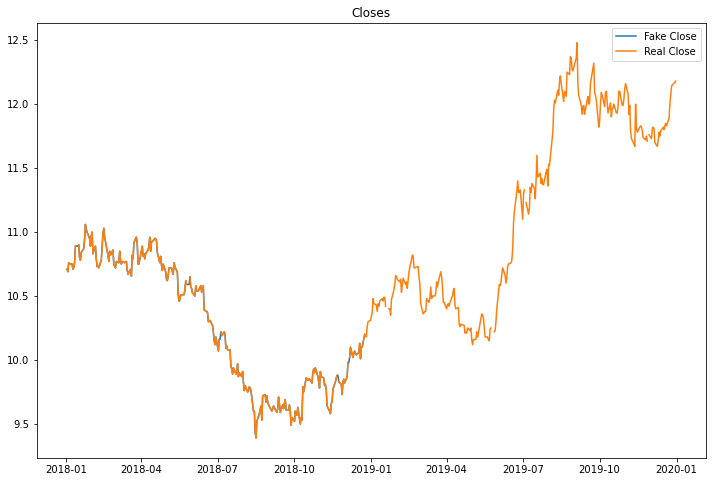

In [91]:
# Plot the df_1 close values against the phys close values for the dates in df_1
plt.figure(figsize=(12, 8))
plt.plot(df_1['Close'], label='Fake Close')
# Plot the close values from the phys df for the same dates in df_1
plt.plot(phys['Close'].loc['2018-01-01':'2019-12-31'], label='Real Close')
plt.title('Closes')
plt.legend()
plt.show()

In [92]:
print(f'Number of days in dataset: {len(df_1)}')

Number of days in dataset: 252


In [93]:
trainset = np.arange(0, 252)
df_1 = df_1.iloc[trainset, :]  # use only first year of data for training

In [94]:
# coint_t: Cointegration test statistic (t-statistic) for the null hypothesis that the two series are not cointegrated.
# pvalue: MacKinnon's approximate p-value
# crit_value: Critical values for the test statistic at the 1 %, 5 %, and 10 % levels.
coint_t, pvalue, crit_value = coint(
    df_1['Close'], df_1['NAV']
    )
print(f'cointegration test statistic: {coint_t}')
print(f'p-value: {pvalue}')
print(f'critical values: {crit_value}')

cointegration test statistic: -3.9292220152892314
p-value: 0.009035840270535207
critical values: [-3.94060523 -3.36058133 -3.06139039]


hedge ratio: 0.991047033736941


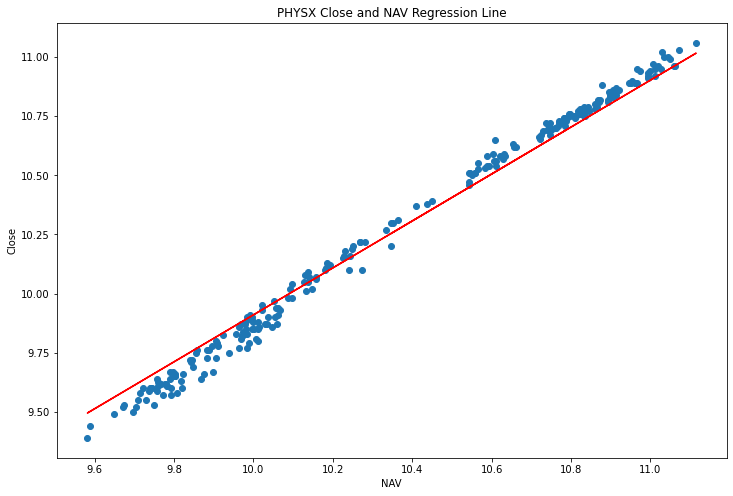

In [95]:
# Determine the hedge ratio
"""
Using statsmodels OLS to find the hedge ratio.
Where the slope of the regression line (line that minimizes the sum of the squared residuals) from OLS is the hedge ratio.
"""
model = OLS(df_1['Close'], df_1['NAV'])
results = model.fit()
hedge_ratio = results.params[0]
print(f'hedge ratio: {hedge_ratio}')
# Plot the regression line
plt.figure(figsize=(12, 8))
plt.scatter(df_1['NAV'], df_1['Close'])
plt.plot(df_1['NAV'], results.fittedvalues, color='r')
plt.title('PHYSX Close and NAV Regression Line')
plt.xlabel('NAV')
plt.ylabel('Close')
plt.show()

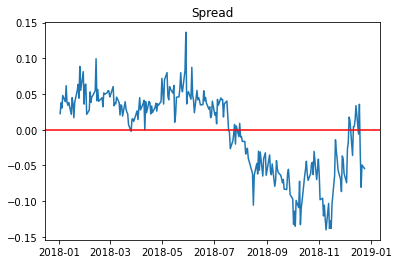

In [96]:
# spread = GLD - hedge_ratio * GDX
spread = df_1['Close'] - hedge_ratio * df_1['NAV']
plt.plot(spread)
plt.title('Spread')
plt.axhline(0, color='red')
plt.show()

Repeating the same steps for the years 2021-2023

In [109]:
df_2 = df['2020-01-01':'2023-01-01']
df_2.head()

,Close,NAV
Date,,
2020-01-02,12.28,12.3915
2020-01-03,12.41,12.5773
2020-01-06,12.54,12.6859
2020-01-07,12.64,12.7552
2020-01-08,12.56,12.6105


In [110]:
# Fill the nan values with the average of the previous day and next day's price
df_2['Close'].fillna(method='ffill', inplace=True)
df_2['NAV'].fillna(method='ffill', inplace=True)
df_2['Close'].fillna(method='bfill', inplace=True)
df_2['NAV'].fillna(method='bfill', inplace=True)

/var/folders/rs/k8yvpht95zxbr8d7v79msjk00000gn/T/ipykernel_4094/2714760841.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_2['Close'].fillna(method='ffill', inplace=True)
/var/folders/rs/k8yvpht95zxbr8d7v79msjk00000gn/T/ipykernel_4094/2714760841.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_2['NAV'].fillna(method='ffill', inplace=True)
/var/folders/rs/k8yvpht95zxbr8d7v79msjk00000gn/T/ipykernel_4094/2714760841.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/index

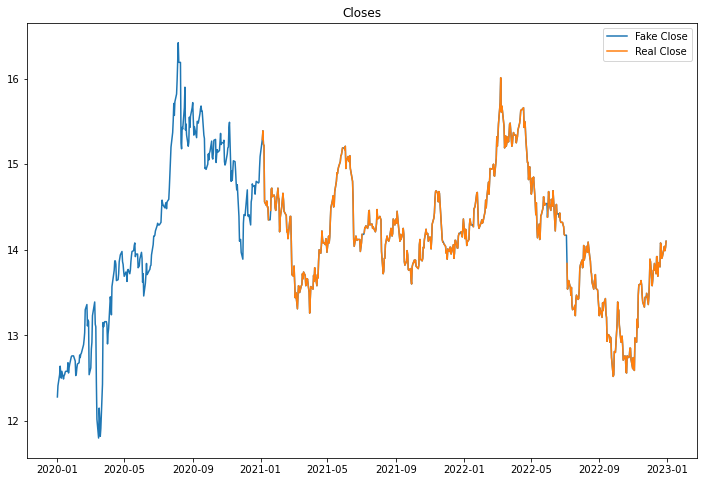

In [111]:
# Plot the df_2 close values against the phys close values for the dates in df_2
plt.figure(figsize=(12, 8))
plt.plot(df_2['Close'], label='Fake Close')
# Plot the close values from the phys df for the same dates in df_1
plt.plot(phys['Close'].loc['2021-01-01':'2023-01-01'], label='Real Close')
plt.title('Closes')
plt.legend()
plt.show()

In [112]:
#trainset = np.arange(0, 252)
#df_2 = df_2.iloc[trainset, :]  # use only first year of data for training

In [113]:
# coint_t: Cointegration test statistic (t-statistic) for the null hypothesis that the two series are not cointegrated.
# pvalue: MacKinnon's approximate p-value
# crit_value: Critical values for the test statistic at the 1 %, 5 %, and 10 % levels.
coint_t, pvalue, crit_value = coint(
    df_2['Close'], df_2['NAV']
    )
print(f'cointegration test statistic: {coint_t}')
print(f'p-value: {pvalue}')
print(f'critical values: {crit_value}')

cointegration test statistic: -3.555070194711001
p-value: 0.027815913097020133
critical values: [-3.91073844 -3.34408705 -3.04996981]


hedge ratio: 0.9883036014219037


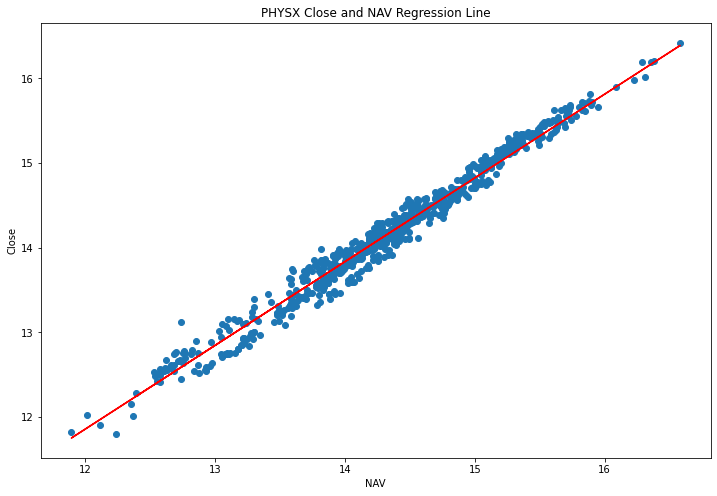

In [114]:
# Determine the hedge ratio
"""
Using statsmodels OLS to find the hedge ratio.
Where the slope of the regression line (line that minimizes the sum of the squared residuals) from OLS is the hedge ratio.
"""
model = OLS(df_2['Close'], df_2['NAV'])
results = model.fit()
hedge_ratio = results.params[0]
print(f'hedge ratio: {hedge_ratio}')
# Plot the regression line
plt.figure(figsize=(12, 8))
plt.scatter(df_2['NAV'], df_2['Close'])
plt.plot(df_2['NAV'], results.fittedvalues, color='r')
plt.title('PHYSX Close and NAV Regression Line')
plt.xlabel('NAV')
plt.ylabel('Close')
plt.show()

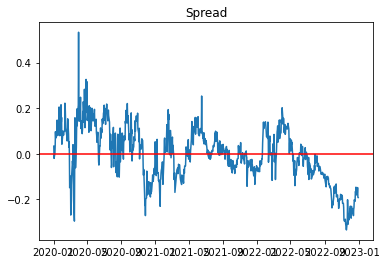

In [115]:
# spread = GLD - hedge_ratio * GDX
spread = df_2['Close'] - hedge_ratio * df_2['NAV']
plt.plot(spread)
plt.title('Spread')
plt.axhline(0, color='red')
plt.show()

Determining the beta between PHYSX and GLD

In [117]:
# Get GLD data from yfinance for the same time period as phys
gld = yf.download('GLD', start='2018-01-01', end='2023-01-01')
gld.head()

[*********************100%***********************]  1 of 1 completed


,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2018-01-02,124.660004,125.180000,124.389999,125.150002,125.150002,11762500
2018-01-03,125.050003,125.089996,124.099998,124.820000,124.820000,7904300
2018-01-04,124.889999,125.849998,124.739998,125.459999,125.459999,7329700
2018-01-05,124.930000,125.480003,124.830002,125.330002,125.330002,5739900
2018-01-08,125.199997,125.320000,124.900002,125.309998,125.309998,3566700


In [122]:
# Calculate the beta between the two assets
covariance = phys['NAV'].pct_change().cov(gld['Adj Close'].pct_change())
variance = gld['Adj Close'].pct_change().var()
beta = covariance / variance
print(beta)

0.9742585592515429


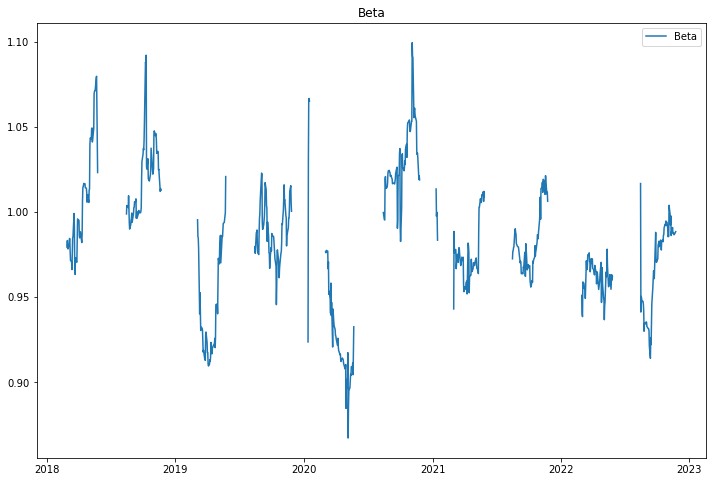

In [125]:
# Plot the beta over time
plt.figure(figsize=(12, 8))
plt.plot((phys['NAV'].pct_change().rolling(30).cov(gld['Adj Close'].pct_change()) / (gld['Adj Close'].pct_change().rolling(30).var())), label='Beta')
plt.title('Beta')
plt.legend()
plt.show()